In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [105]:
#load single bank data as dataframe
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [106]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
bank_df.head()

,year,income,amount
76234,2013,4,1
77074,2013,19,1
232210,2011,33,1
229962,2011,16,2
80784,2013,41,3


In [177]:
bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
bank_df['pct_cnt_amt'] = bank_df.groupby(['amount']).pct_amt.count() / bank_df.groupby(['amount']).pct_amt.count().sum()
bank_df['cumul_cnt_pct_amt'] = bank_df.pct_cnt_amt.cumsum()

#create dataframe for amount * count to show cumulative percent by volume of loans
amtXcnt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count()) #* bank_df.amount
amtXcnt_df['amount'] = amtXcnt_df.index
amtXcnt_df['vol'] = amtXcnt_df.amount * amtXcnt_df.pct_amt
amtXcnt_df['count'] = amtXcnt_df.pct_amt
amtXcnt_df.drop('pct_amt', axis=1, inplace=True)
amtXcnt_df['pct'] = amtXcnt_df.vol / amtXcnt_df.vol.sum()
amtXcnt_df['cumul_pct'] = amtXcnt_df.pct.cumsum()


#create percent and cumulative percents
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value
inc_df['amtXct'] = inc_df.groupby(['income']).pct_inc.count() * inc_df.income

#create percent and cumulative percents by count and count times amount
inc_df['pct_cnt_inc'] = inc_df.groupby(['income']).pct_amt.count() / inc_df.groupby(['income']).pct_amt.count().sum()
inc_df['cumul_cnt_pct_inc'] = inc_df.pct_cnt_inc.cumsum()
inc_df['incXcnt'] = inc_df.groupby(['amount']).pct_inc.count() * inc_df.income
inc_df['incXcnt_pct'] = inc_df.incXcnt / inc_df.incXcnt.sum()

#create dataframe for amount * count to show cumulative percent by volume of loans
incXcnt_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count()) #* bank_df.amount
incXcnt_df['income'] = incXcnt_df.index
incXcnt_df['vol'] = incXcnt_df.income * incXcnt_df.pct_inc
incXcnt_df['count'] = incXcnt_df.pct_inc
incXcnt_df.drop('pct_inc', axis=1, inplace=True)
incXcnt_df['pct'] = incXcnt_df.vol / incXcnt_df.vol.sum()
incXcnt_df['cumul_pct'] = incXcnt_df.pct.cumsum()



In [92]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

       year  income  amount      mult       pct_amt  cumul_amt_pct   pct_inc  \
7036   2014      56       7  0.125000  1.892840e-07   1.892840e-07  0.000004   
9916   2014      67       8  0.119403  2.163245e-07   4.056085e-07  0.000004   
1090   2014      25       8  0.320000  2.163245e-07   6.219331e-07  0.000002   
1468   2014      28       9  0.321429  2.433651e-07   8.652982e-07  0.000002   
33498  2014     140      10  0.071429  2.704057e-07   1.135704e-06  0.000009   

       cumul_inc_pct  pct_count_amt  pct_cnt_amt  cumul_cnt_pct_amt  cntXamt  \
7036        0.000004            NaN          NaN                NaN      NaN   
9916        0.000008            NaN          NaN                NaN      NaN   
1090        0.000009       0.000131     0.000131           0.000131     80.0   
1468        0.000011       0.000053     0.000053           0.000184     36.0   
33498       0.000020            NaN          NaN                NaN      NaN   

       amtXcnt  amtXcnt_pct  
7036    

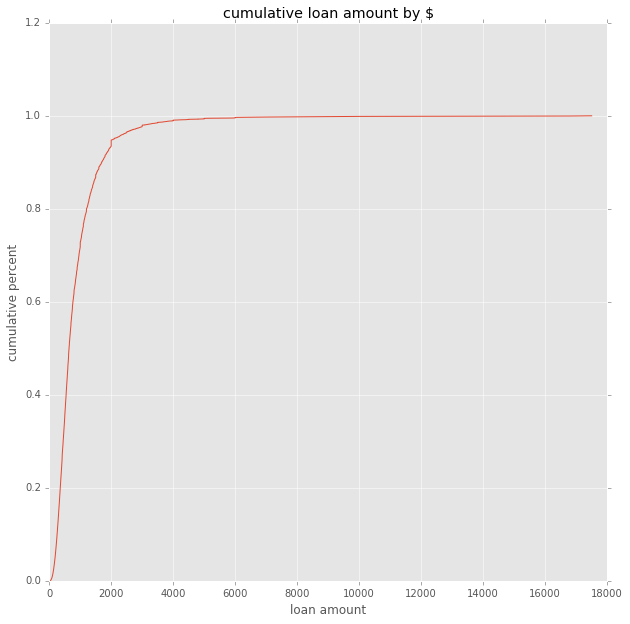

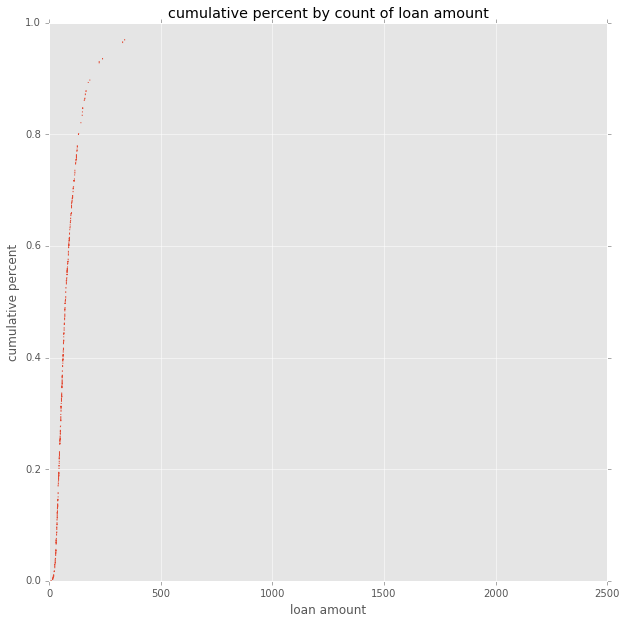

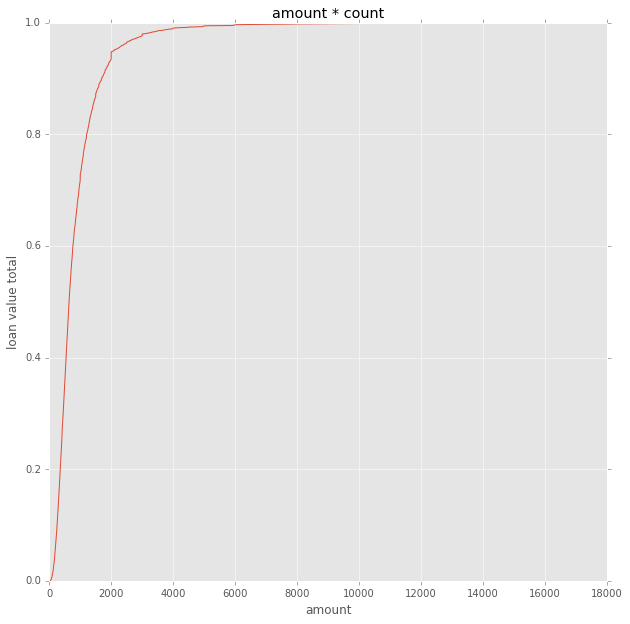

In [178]:
#graph cumulative sum of % of income and % of loan amount 
y = bank_df.cumul_amt_pct
y1 = bank_df.cumul_cnt_pct_amt
x = bank_df.amount
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.title('cumulative loan amount by $')
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount')
plt.show(cumul_cnt)

#print(x, y2)
amtXcnt = plt.figure(figsize=(10,10))
x2 = amtXcnt_df.amount
y2 = amtXcnt_df.cumul_pct
plt.plot(x2,y2)
plt.title('amount * count')
plt.xlabel('amount')
plt.ylabel('loan value total')
plt.show(amtXcnt)

#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

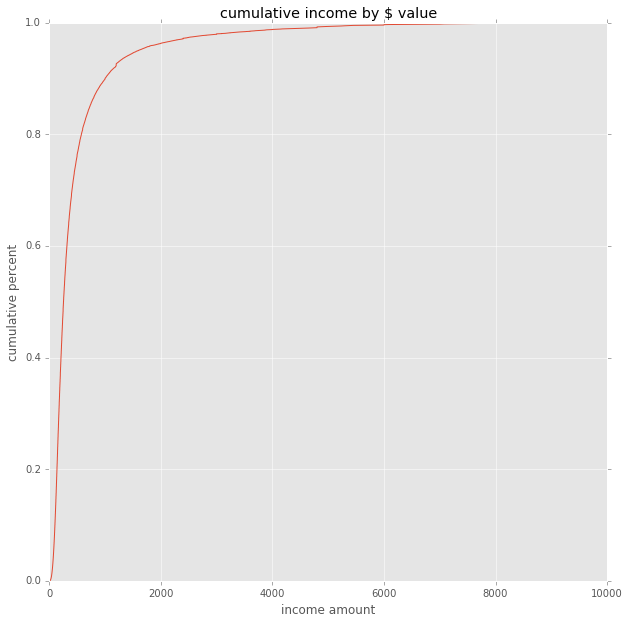

In [183]:

y = inc_df.cumul_inc_pct
x = inc_df.income

cumul_inc = plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.title('cumulative income by $ value')
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


#FIXME cutting the tail off of income data may show more information
#long tail of incomes skews visualization of cumulative percents based on $ value

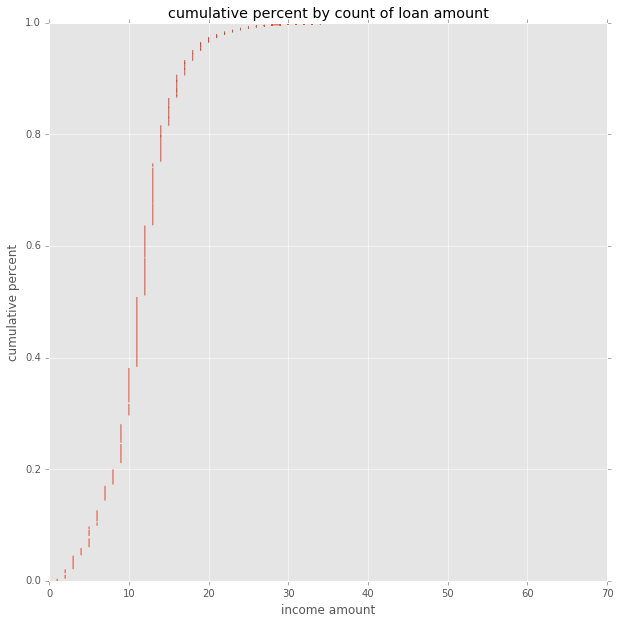

In [184]:

y1 = inc_df.cumul_cnt_pct_inc
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x,y1)
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount')
plt.show(cumul_cnt)

#shows the majority of loans by count have 25k input, check data for this, it doesn't seem right

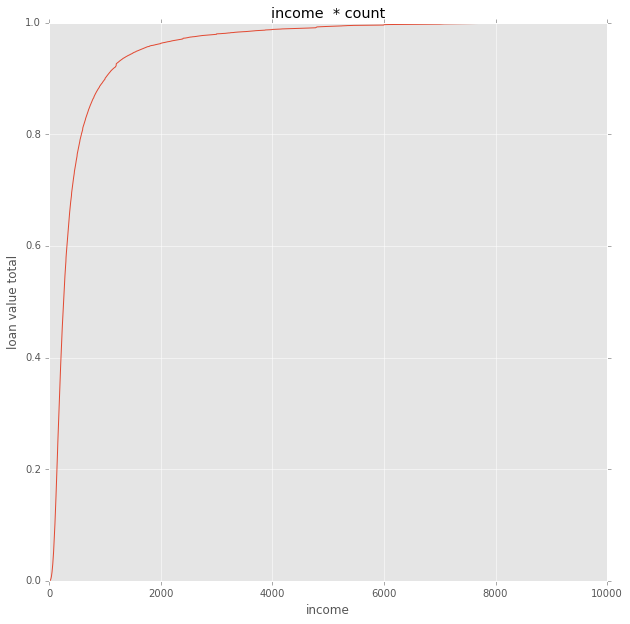

In [185]:
incXcnt = plt.figure(figsize=(10,10))
x2 = incXcnt_df.income
y2 = incXcnt_df.cumul_pct
plt.plot(x2,y2)
plt.title('income  * count')
plt.xlabel('income')
plt.ylabel('loan value total')
plt.show(incXcnt)


437.434185441 std
485.58242624 mean
377.0 median
2500.0 max mult
0.0352564102564 min mult
1720.0 98%
612.0 q3
217.0 q1
55.0 02%
395.0 iqr
-375.5 min_q 1204.5 max_q


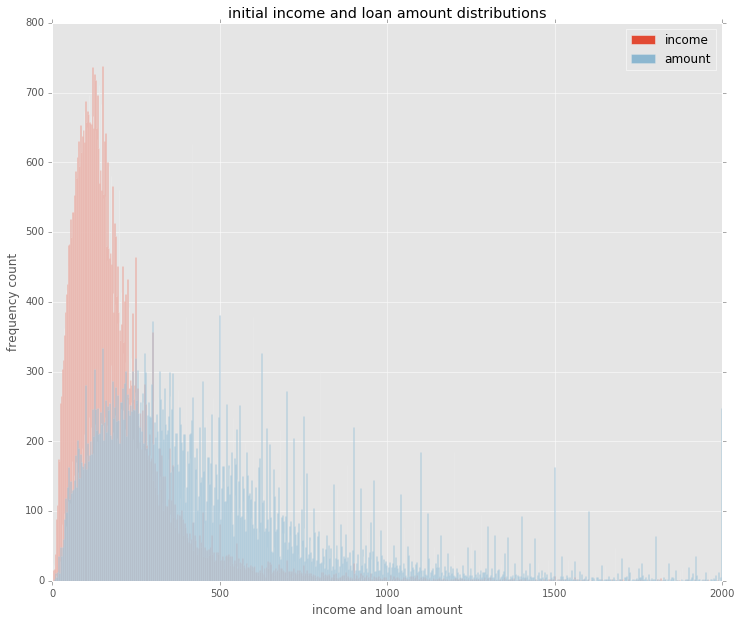

In [49]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), '98%')
print(bank_df.amount.quantile(q=.75), 'q3')
print(bank_df.amount.quantile(q=.25), 'q1')
print(bank_df.amount.quantile(q=.02), '02%')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,2000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

std 91.2671236696
mean 109.266766579
median 92.0
max_mult 75.0
min_mult 0.172413793103
q98 347.78
q02 20.0
q75 132.0
q25 58.0
iqr 74.0
min_q -53.0
max_q 243.0
[   0.            5.05050505   10.1010101    15.15151515   20.2020202
   25.25252525   30.3030303    35.35353535   40.4040404    45.45454545
   50.50505051   55.55555556   60.60606061   65.65656566   70.70707071
   75.75757576   80.80808081   85.85858586   90.90909091   95.95959596
  101.01010101  106.06060606  111.11111111  116.16161616  121.21212121
  126.26262626  131.31313131  136.36363636  141.41414141  146.46464646
  151.51515152  156.56565657  161.61616162  166.66666667  171.71717172
  176.76767677  181.81818182  186.86868687  191.91919192  196.96969697
  202.02020202  207.07070707  212.12121212  217.17171717  222.22222222
  227.27272727  232.32323232  237.37373737  242.42424242  247.47474747
  252.52525253  257.57575758  262.62626263  267.67676768  272.72727273
  277.77777778  282.82828283  287.87878788  292.92929293  297

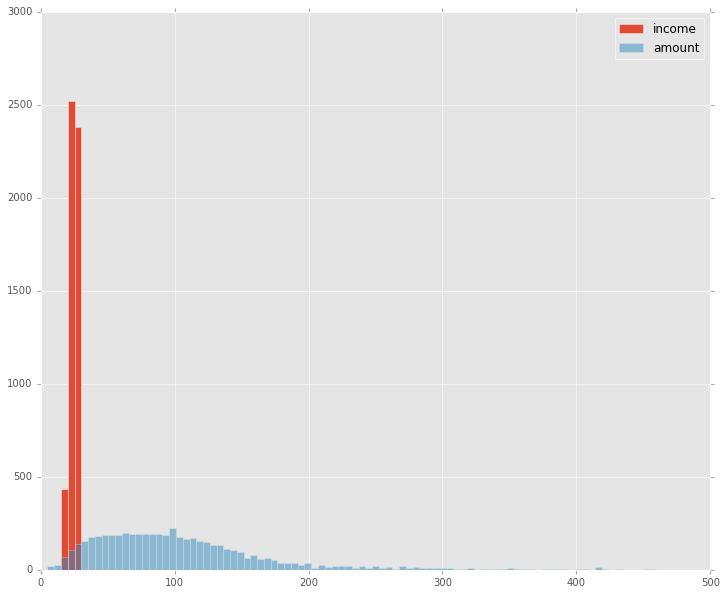

In [24]:
bin_2030 = bank_df[(bank_df.income >=20) & (bank_df.income < 30)] #create bin of 20 to 30k income
#generate descriptive statistics and store for later comparison
bin_2030_stats = OrderedDict({})
bin_2030_stats['std']= bin_2030.amount.std()
bin_2030_stats['mean'] = bin_2030.amount.mean()
bin_2030_stats['median'] = bin_2030.amount.median()
bin_2030_stats['max_mult'] = bin_2030.mult.max()
bin_2030_stats['min_mult'] = bin_2030.mult.min()
bin_2030_stats['q98'] = bin_2030.amount.quantile(q=.98)
bin_2030_stats['q02'] = bin_2030.amount.quantile(q=.02)
bin_2030_stats['q75'] = bin_2030.amount.quantile(q=.75)
bin_2030_stats['q25'] = bin_2030.amount.quantile(q=.25)
bin_2030_stats['iqr'] = bin_2030_stats['q75'] - bin_2030_stats['q25']
bin_2030_stats['min_q'] = bin_2030_stats['q25'] - 1.5 * bin_2030_stats['iqr']
bin_2030_stats['max_q'] = bin_2030_stats['q75'] + 1.5 * bin_2030_stats['iqr']

for key, value in bin_2030_stats.items():
    print(key, value)

amt = bin_2030.amount
inc = bin_2030.income
bins = np.linspace(0,500, 100)
#print(bins)
bin_viz = plt.figure(figsize=(12,10))
plt.hist(inc, bins, label='income', alpha=1)
plt.hist(amt, bins, label='amount', alpha=.5)

plt.legend(loc='upper right')
plt.show(bin_viz)
#FIXME add two boxplot viz

In [179]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)

In [180]:
#make data adjustments and calculate desc stat deltas and regraph
#use IQR and quality edits seperately (copy dataframe first)
#use this work to refine income bins and associated loan amount distributions


In [ ]:
#exclude data with quality edit fails